| 지표 | 정의 (전체 데이터 기준) |
| --- | --- |
| **Recency** | `현재 step - 마지막 거래 step` |
| **Frequency** | 전체 거래 횟수 |
| **Monetary** | 전체 거래 금액 합계 / 평균 |

[paysim.db] 연결 및 데이터 정합성 맞추기...
Current Step: 806, Period Start: 63
Executing SQL Query...

Data Loaded! Rows: 99999 (Customers)
      nameOrig  last_step  Frequency  MonetarySum  MonetaryAvg  Recency
0  C1000009135         19          0         0.00         0.00      787
1  C1000015836        163          1     77027.49     77027.49      643
2  C1000018718        138          1     32100.16     32100.16      668
3   C100006663         15          0         0.00         0.00      791
4  C1000071455         42          0         0.00         0.00      764

=== RFM Summary Stats ===
     metric  count       mean   median        std        p90
    Recency  99999    558.699   555.00    143.343    770.000
  Frequency  99999      0.980     1.00      0.755      1.000
MonetarySum  99999 181197.273 43871.60 749712.478 367122.166
MonetaryAvg  99999 156433.569 40664.26 553123.178 333609.584


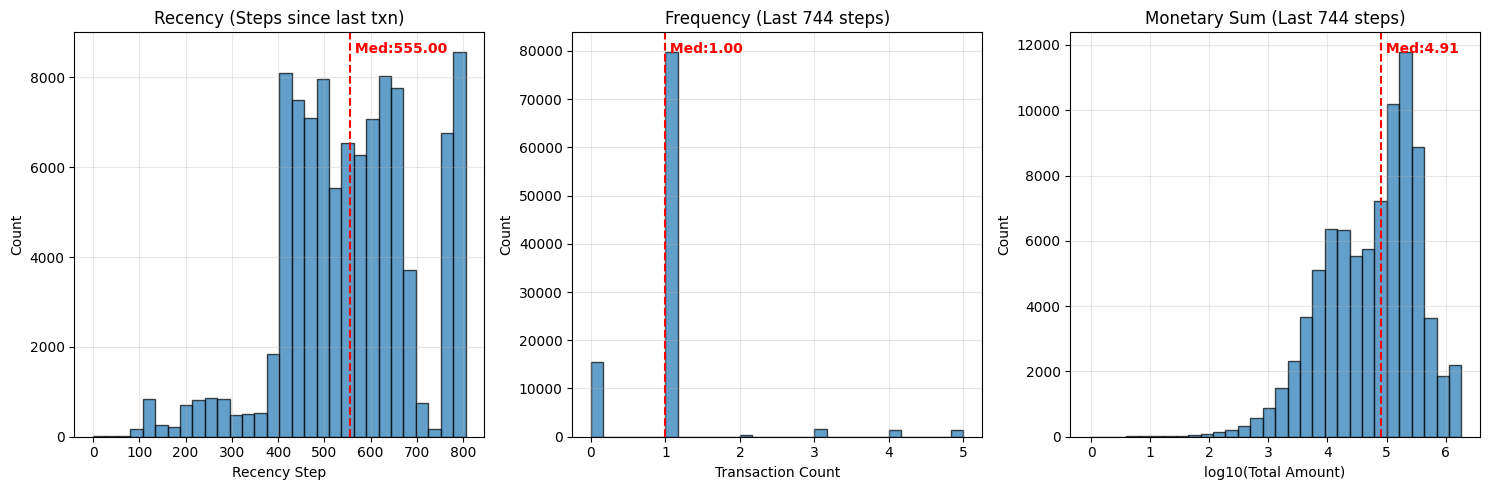


Saved: rfm_sqlite_result.csv


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text

# =========================
# 1) 설정
# =========================
DB_PATH = "paysim.db" 
TABLE   = "PaySim"
period_steps = 744 #과거 데이터 (Step 1 ~ 62)는 제외됨 
clip_pct = 0.99

engine = create_engine(f"sqlite:///{DB_PATH}")

with engine.connect() as conn:
    print(f"[{DB_PATH}] 연결 및 데이터 정합성 맞추기...")

    # [Step 1] 분석 기준 시점(Last Step) 구하기
    # CAST(step AS INTEGER)로 확실하게 정수화
    max_step_query = text(f"SELECT MAX(CAST(step AS INTEGER)) FROM {TABLE}")
    current_step = conn.execute(max_step_query).scalar()
    
    if current_step is None:
        raise ValueError("데이터가 없습니다.")
        
    current_step = int(current_step)
    period_start = current_step - period_steps + 1
    print(f"Current Step: {current_step}, Period Start: {period_start}")

    # [Step 2] RFM 계산 (Python 로직과 100% 일치시키기)
    # Python의 pd.to_numeric(errors='coerce')와 dropna 효과를 내는 쿼리
    print("Executing SQL Query...")
    
    # --파라미터 바인딩(Parameter Binding): :p_start는 이름표임 나중에 실제 변수랑 연결시켜줘야함
    query = text(f"""
        SELECT 
            nameOrig,
            -- 1. Recency용: 조건(CASE WHEN) 없이 전체 기간에서 찾음
            MAX(CAST(step AS INTEGER)) as last_step,
            
            -- Frequency: step을 강제로 정수로 바꾼 뒤 비교
            COUNT(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN 1 END) as Frequency,
            
            -- Monetary: amount를 강제로 실수(Float)로 바꾼 뒤 합산
            -- 데이터가 깨져있으면 0으로 처리되므로 안전함
            COALESCE(SUM(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END), 0) as MonetarySum,
            
            -- MonetaryAvg
            AVG(CASE WHEN CAST(step AS INTEGER) >= :p_start THEN CAST(amount AS FLOAT) END) as MonetaryAvg
        FROM {TABLE}
        WHERE
            -- Python의 dropna()와 같은 역할: 이상한 데이터는 아예 집계에서 뺌
            typeof(step) IN ('integer', 'real') 
            OR (typeof(step) = 'text' AND step GLOB '[0-9]*')
    
        GROUP BY nameOrig
    """)
    
    rfm = pd.read_sql(query, conn, params={"p_start": period_start})

# =========================
# 3) Python 후처리
# =========================
# Recency 계산 (현재 시점 - 마지막 거래 시점)
rfm['Recency'] = current_step - rfm['last_step']

# MonetaryAvg 결측치(거래 없는 경우) 0으로 채우기
rfm['MonetaryAvg'] = rfm['MonetaryAvg'].fillna(0)

print(f"\nData Loaded! Rows: {len(rfm)} (Customers)")
print(rfm.head())

# =========================
# 4) 요약 통계 (Summary Stats)
# =========================
summary = pd.DataFrame({
    'metric': ['Recency','Frequency','MonetarySum','MonetaryAvg'],
    'count':  [rfm['Recency'].notna().sum(),
               rfm['Frequency'].notna().sum(),
               rfm['MonetarySum'].notna().sum(),
               rfm['MonetaryAvg'].notna().sum()],
    'mean':   [rfm['Recency'].mean(),
               rfm['Frequency'].mean(),
               rfm['MonetarySum'].mean(),
               rfm['MonetaryAvg'].mean()],
    'median': [rfm['Recency'].median(),
               rfm['Frequency'].median(),
               rfm['MonetarySum'].median(),
               rfm['MonetaryAvg'].median()],
    'std':    [rfm['Recency'].std(),
               rfm['Frequency'].std(),
               rfm['MonetarySum'].std(),
               rfm['MonetaryAvg'].std()],
    'p90':    [rfm['Recency'].quantile(0.9),
               rfm['Frequency'].quantile(0.9),
               rfm['MonetarySum'].quantile(0.9),
               rfm['MonetaryAvg'].quantile(0.9)]
})
print("\n=== RFM Summary Stats ===")
print(summary.round(3).to_string(index=False))

# =========================
# 5) 시각화 (Visualization)
# =========================
# 시각화 함수 정의
def hist_with_median(ax, data, bins, title, xlabel, clip_at=None, log=False):
    x = data.copy()
    if clip_at is not None:
        cap = x.quantile(clip_at)
        x = x.clip(upper=cap)
    if log:
        # 0 이하 값은 로그 변환 불가하므로 제외
        x = x[x > 0] 
        x = np.log10(x)
        xlabel = f"log10({xlabel})"
    
    x = x.dropna()

    ax.hist(x, bins=bins, edgecolor='black', alpha=0.7)
    
    if len(x) > 0:
        med = x.median()
        ax.axvline(med, color='red', linestyle='--', linewidth=1.5)
        ax.text(med, ax.get_ylim()[1]*0.95, f" Med:{med:.2f}", color='red', fontweight='bold')
        
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)

figsize = (15, 5) # 가로로 긴 형태
fig, axes = plt.subplots(1, 3, figsize=figsize)

# 5-1) Recency
hist_with_median(axes[0],
                 rfm['Recency'],
                 bins=30,
                 title="Recency (Steps since last txn)",
                 xlabel="Recency Step")

# 5-2) Frequency
hist_with_median(axes[1],
                 rfm['Frequency'],
                 bins=30,
                 title=f"Frequency (Last {period_steps} steps)",
                 xlabel="Transaction Count",
                 clip_at=clip_pct)

# 5-3) MonetarySum
hist_with_median(axes[2],
                 rfm['MonetarySum'],
                 bins=30,
                 title=f"Monetary Sum (Last {period_steps} steps)",
                 xlabel="Total Amount",
                 clip_at=clip_pct,
                 log=True)

plt.tight_layout()
plt.show()

# =========================
# 6) 결과 저장
# =========================
# 분석 결과를 CSV로 저장 (필요시)
rfm.to_csv("rfm_sqlite_result.csv", index=False)
print("\nSaved: rfm_sqlite_result.csv")


=== RFM Summary Stats ===
     metric  count       mean   median        std        p90
    Recency  99999    558.699   555.00    143.343    770.000
  Frequency  99999      0.980     1.00      0.755      1.000
MonetarySum  99999 181197.273 43871.60 749712.478 367122.166
MonetaryAvg  99999 156433.569 40664.26 553123.178 333609.584

=== Insight Cards ===
• [Recency] 현재 step=806, 중위수=555 (작을수록 최근 거래 고객).
• [Frequency] 최근 744 step 기준 중위수=1회.
• [Monetary] 상위 10% 고객이 전체 거래금액의 약 60.4% 차지.


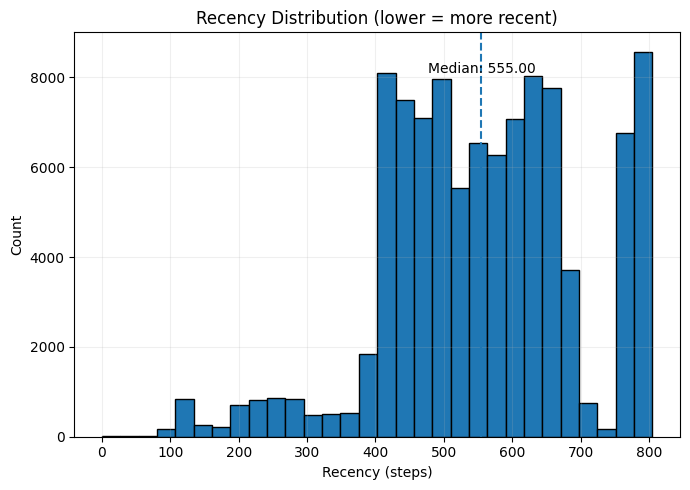

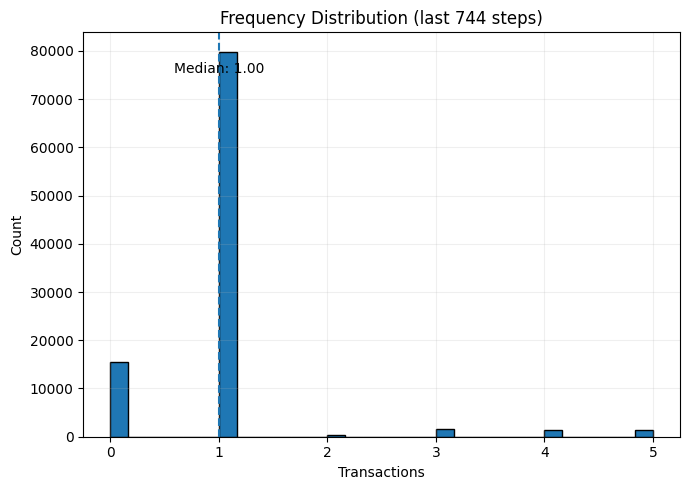

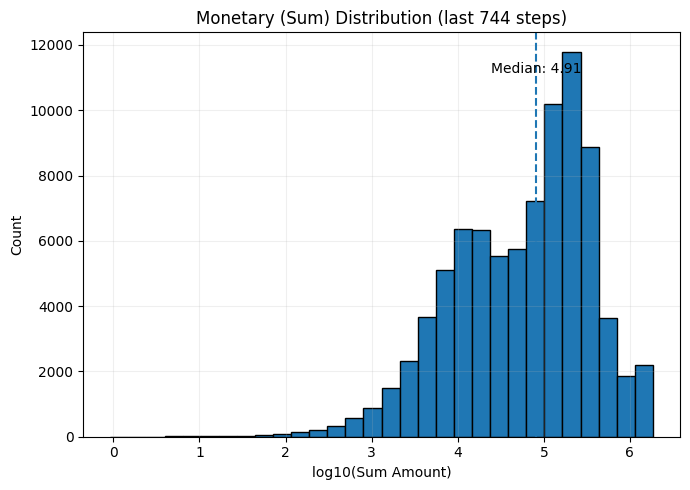


Saved: rfm_explore_output.csv


In [7]:
import mysql.connector
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sqlalchemy import create_engine, text

USER = "root"
PWD  = "Lee030414*"
HOST = "localhost"
PORT = 3306
DB   = "paysim"
TABLE= "db"


# ▶ 분석 기간(step 단위) 설정
#   PaySim은 744 step ≈ 30일. 최근 period_steps 기준으로 F/M을 계산.
period_steps = 744   # 필요 시 변경

# ▶ 금액/빈도 분포가 길게 늘어질 수 있어 상위 퍼센타일 클리핑 옵션
clip_pct = 0.99      # 99퍼센타일 상한으로 시각화 범위 깔끔히

# =========================
# 1) 데이터 적재
# =========================
engine = create_engine(f"mysql+pymysql://{USER}:{PWD}@{HOST}:{PORT}/{DB}")
with engine.connect() as conn:
    # 필요한 컬럼만 (성능)
    # 필수 컬럼: step, nameOrig, amount
    df = pd.read_sql(text(f"""
        SELECT step, nameOrig, amount
        FROM {TABLE}
    """), conn)

# 기본 체크(강력한 전처리)
assert {'step','nameOrig','amount'}.issubset(df.columns), "필수 컬럼(step,nameOrig,amount) 확인 필요"
# 1. 숫자가 아닌 값(문자열, 공백 등)을 NaN(결측치)으로 강제 변환
df['step'] = pd.to_numeric(df['step'], errors='coerce')
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
# 2. step, nameOrig, amount 중 하나라도 비어있으면(NaN) 행을 통째로 삭제!
df = df.dropna(subset=['step','nameOrig','amount'])
#amount가 비어있거나 이상한 문자가 섞인 거래 내역은 아예 없던 일처럼 삭제됩니다. 그래서 **Frequency(건수)**가 줄어듭니다.

# =========================
# 2) 현재 시점(step) 정의
#   Recency = current_step - 마지막 거래 step(송신자 기준)
#   값이 작을수록 최근 거래
# =========================
current_step = int(df['step'].max())

# =========================
# 3) 분석 기간 필터(최근 period_steps만)
#   Frequency/Monetary는 "특정 기간" 기준
#   Recency는 전체 중 마지막 거래 시점을 사용(일반 정의)
# =========================
period_start = current_step - period_steps + 1
df_period = df[df['step'].between(period_start, current_step)].copy()

# =========================
# 4) R/F/M 계산
# =========================
# R: 이름별 마지막 거래 시점
last_step = df.groupby('nameOrig', as_index=False).agg(last_step=('step','max'))
last_step['Recency'] = current_step - last_step['last_step']

# F: 최근 period_steps 내 거래 횟수
freq = df_period.groupby('nameOrig', as_index=False).agg(Frequency=('step','count'))

# M: 최근 period_steps 내 금액 합계/평균(둘 다 계산해두고 합계 기준으로 기본 시각화)
monetary = df_period.groupby('nameOrig', as_index=False).agg(
    MonetarySum=('amount','sum'),
    MonetaryAvg=('amount','mean')
)

# merge
rfm = (last_step
       .merge(freq, on='nameOrig', how='left')
       .merge(monetary, on='nameOrig', how='left')
       .fillna({'Frequency':0, 'MonetarySum':0, 'MonetaryAvg':0})
)

# =========================
# 5) 요약 통계 테이블
# =========================
summary = pd.DataFrame({
    'metric': ['Recency','Frequency','MonetarySum','MonetaryAvg'],
    'count':  [rfm['Recency'].notna().sum(),
               rfm['Frequency'].notna().sum(),
               rfm['MonetarySum'].notna().sum(),
               rfm['MonetaryAvg'].notna().sum()],
    'mean':   [rfm['Recency'].mean(),
               rfm['Frequency'].mean(),
               rfm['MonetarySum'].mean(),
               rfm['MonetaryAvg'].mean()],
    'median': [rfm['Recency'].median(),
               rfm['Frequency'].median(),
               rfm['MonetarySum'].median(),
               rfm['MonetaryAvg'].median()],
    'std':    [rfm['Recency'].std(),
               rfm['Frequency'].std(),
               rfm['MonetarySum'].std(),
               rfm['MonetaryAvg'].std()],
    'p90':    [rfm['Recency'].quantile(0.9),
               rfm['Frequency'].quantile(0.9),
               rfm['MonetarySum'].quantile(0.9),
               rfm['MonetaryAvg'].quantile(0.9)]
})
print("\n=== RFM Summary Stats ===")
print(summary.round(3).to_string(index=False))

# =========================
# 6) 간단 해설 카드(자동 생성)
#   대시보드 텍스트 카드용 문구 초안
# =========================
r_med = rfm['Recency'].median()
f_med = rfm['Frequency'].median()
m10_share = (rfm['MonetarySum']
             .sort_values(ascending=False)
             .iloc[:max(1, int(len(rfm)*0.10))].sum()) / max(1, rfm['MonetarySum'].sum())

insights = [
    f"[Recency] 현재 step={current_step}, 중위수={int(r_med)} (작을수록 최근 거래 고객).",
    f"[Frequency] 최근 {period_steps} step 기준 중위수={int(f_med)}회.",
    f"[Monetary] 상위 10% 고객이 전체 거래금액의 약 {m10_share*100:.1f}% 차지."
]
print("\n=== Insight Cards ===")
for line in insights:
    print("• " + line)

# =========================
# 7) 시각화 (그래프 3개)
#    - Recency: 히스토그램
#    - Frequency: 히스토그램
#    - Monetary (Sum): 히스토그램 (꼬리 완화 위해 클리핑/로그)
# =========================

def hist_with_median(ax, data, bins, title, xlabel, clip_at=None, log=False):
    x = data.copy()
    if clip_at is not None:
        cap = x.quantile(clip_at)
        x = x.clip(upper=cap)
    if log:
        x = np.log10(x.replace(0, np.nan))  # 0 제거(로그불가)
        xlabel = f"log10({xlabel})"
        x = x.dropna()

    ax.hist(x, bins=bins, edgecolor='black')
    med = x.median()
    ax.axvline(med, linestyle='--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel("Count")
    ax.grid(alpha=0.2)
    # 중앙값 주석
    ax.text(med, ax.get_ylim()[1]*0.9, f"Median: {med:.2f}", ha='center')

figsize = (7,5)

# 7-1) Recency
plt.figure(figsize=figsize)
ax1 = plt.gca()
hist_with_median(ax1,
                 rfm['Recency'],
                 bins=30,
                 title="Recency Distribution (lower = more recent)",
                 xlabel="Recency (steps)")
plt.tight_layout()
plt.show()

# 7-2) Frequency (클리핑)
plt.figure(figsize=figsize)
ax2 = plt.gca()
hist_with_median(ax2,
                 rfm['Frequency'],
                 bins=30,
                 title=f"Frequency Distribution (last {period_steps} steps)",
                 xlabel="Transactions",
                 clip_at=clip_pct)
plt.tight_layout()
plt.show()

# 7-3) MonetarySum (클리핑 + 로그축)
plt.figure(figsize=figsize)
ax3 = plt.gca()
hist_with_median(ax3,
                 rfm['MonetarySum'],
                 bins=30,
                 title=f"Monetary (Sum) Distribution (last {period_steps} steps)",
                 xlabel="Sum Amount",
                 clip_at=clip_pct,
                 log=True)
plt.tight_layout()
plt.show()

# =========================
# 8) 결과 저장(옵션): CSV로 내보내기
# =========================
rfm_out = rfm[['nameOrig','Recency','Frequency','MonetarySum','MonetaryAvg']].copy()
rfm_out.to_csv("rfm_explore_output.csv", index=False)
print("\nSaved: rfm_explore_output.csv")


